<a href="https://colab.research.google.com/github/jordisc97/team9_boehringer/blob/main/Boeringher_team9_Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

In [16]:
import lightgbm as lgb
from sklearn.metrics import recall_score

# Custom recall metric for LightGBM to penalize False Negatives
def custom_recall_metric(y_true, y_pred):
    """
    Custom recall metric for LightGBM to penalize False Negatives.
    """
    preds_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    recall = recall_score(y_true, preds_binary)
    return 'recall', recall, True  # True means higher is better (maximize recall)


# Boehringer hackathon 2024

## Read data

In [17]:
# to run locally
path = 'full_train_with_oof.csv'
df = pd.read_csv(path, sep=",")

In [18]:
# Modify the URL to access the raw content of the CSV file
# url = 'https://raw.githubusercontent.com/jordisc97/team9_boehringer/main/train_notebooks/full_train_with_oof.csv'
# df = pd.read_csv(url, sep=",")

# Make a copy of the df
df_hack = df.copy()
display(df)

,Patient,ImagePath,Label,Age,Weeks,FVC,Sex,SmokingStatus,min_FVC,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121
0,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,-4,2315.0,Male,Ex-smoker,2315.0,0.0,0.984993,0.69746,0.442795
1,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,5,2214.0,Male,Ex-smoker,2315.0,9.0,0.984993,0.69746,0.442795
2,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,7,2061.0,Male,Ex-smoker,2315.0,11.0,0.984993,0.69746,0.442795
3,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,9,2144.0,Male,Ex-smoker,2315.0,13.0,0.984993,0.69746,0.442795
4,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,11,2069.0,Male,Ex-smoker,2315.0,15.0,0.984993,0.69746,0.442795
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,31,2908.0,Male,Never smoked,NaN,31.0,0.800631,0.12026,0.400990
1565,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,43,2975.0,Male,Never smoked,2925.0,43.0,0.800631,0.12026,0.400990
1566,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,43,2975.0,Male,Never smoked,NaN,43.0,0.800631,0.12026,0.400990
1567,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,59,2774.0,Male,Never smoked,2925.0,59.0,0.800631,0.12026,0.400990


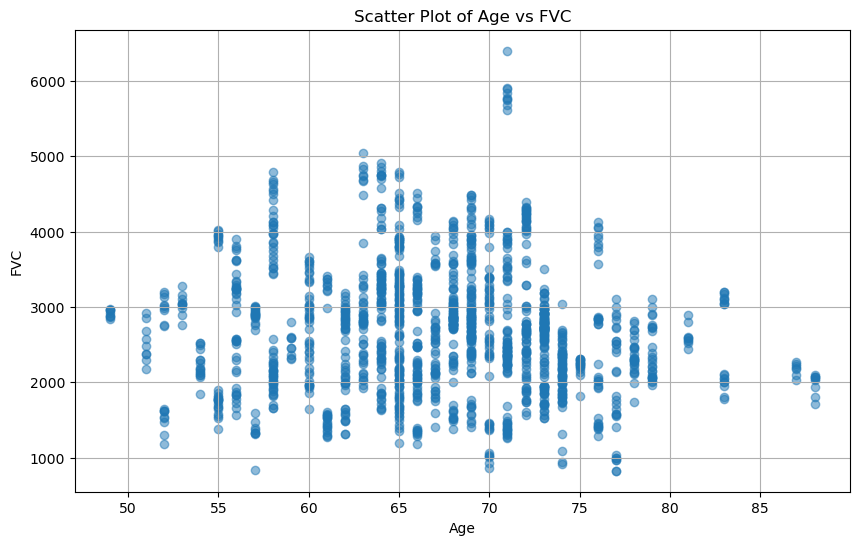

In [19]:
import matplotlib.pyplot as plt

# Plot scatter Age vs FVC
plt.figure(figsize=(10, 6))
plt.scatter(df_hack['Age'], df_hack['FVC'], alpha=0.5)
plt.title('Scatter Plot of Age vs FVC')
plt.xlabel('Age')
plt.ylabel('FVC')
plt.grid(True)
plt.show()

## Feature Engineering
+ Adding max_FVC
+ Encode the categorical values
+ Drop unwanted columns
+ Groupby the last row per patient

In [20]:
# Adding max_FVC and max_FVC
df_hack['max_FVC'] = df_hack.groupby('Patient')['FVC'].transform('max')
df_hack['min_FVC'] = df_hack.groupby('Patient')['FVC'].transform('min')

In [21]:
# Encode Sex and SmokingStatus
df_hack['Sex'] = df_hack['Sex'].map({'Male': 1, 'Female': 2})
df_hack['SmokingStatus'] = df_hack['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 2,  'Currently smokes': 5})

In [22]:
# Encode Parient
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'Category' column
df_hack['Patient_encoded'] = le.fit_transform(df_hack['Patient'])

In [23]:
# Drop Image Path
df_hack = df_hack.drop(columns=['ImagePath'])

In [24]:
# Groupby the last row per patient
# df_hack = df_hack.groupby('Patient').tail(1)

In [25]:
display(df_hack)

,Patient,Label,Age,Weeks,FVC,Sex,SmokingStatus,min_FVC,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121,max_FVC,Patient_encoded
0,ID00007637202177411956430,1,79.0,-4,2315.0,1,2,2000.0,0.0,0.984993,0.69746,0.442795,2315.0,0
1,ID00007637202177411956430,1,79.0,5,2214.0,1,2,2000.0,9.0,0.984993,0.69746,0.442795,2315.0,0
2,ID00007637202177411956430,1,79.0,7,2061.0,1,2,2000.0,11.0,0.984993,0.69746,0.442795,2315.0,0
3,ID00007637202177411956430,1,79.0,9,2144.0,1,2,2000.0,13.0,0.984993,0.69746,0.442795,2315.0,0
4,ID00007637202177411956430,1,79.0,11,2069.0,1,2,2000.0,15.0,0.984993,0.69746,0.442795,2315.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,ID00426637202313170790466,1,73.0,31,2908.0,1,0,2712.0,31.0,0.800631,0.12026,0.400990,2978.0,174
1565,ID00426637202313170790466,1,73.0,43,2975.0,1,0,2712.0,43.0,0.800631,0.12026,0.400990,2978.0,174
1566,ID00426637202313170790466,1,73.0,43,2975.0,1,0,2712.0,43.0,0.800631,0.12026,0.400990,2978.0,174
1567,ID00426637202313170790466,1,73.0,59,2774.0,1,0,2712.0,59.0,0.800631,0.12026,0.400990,2978.0,174


## Model Training
+ Split train and test
+ Cutom loss function to minimize False Negatives

### Results:
+ No image predictions: Recall Score: 0.9032258064516129
+ With image predictions: 0.967741935483871

In [26]:
FEATURES = [
 'Age',
#  'Weeks',
 'FVC',
 'Sex',
 'SmokingStatus',
#  'min_FVC',
 'base_week',
 'OOF_resnet34',
 'OOF_squeezenet1_0',
 'OOF_densenet121',
#  'max_FVC',
]

In [28]:
df_hack.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,Label,Age,Weeks,FVC,Sex,SmokingStatus,min_FVC,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121,max_FVC,Patient_encoded
Label,1.000000,-0.154505,-0.000969,-0.528426,-0.017224,-0.197224,-0.554535,-0.003479,0.110269,0.033317,0.055113,-0.514137,0.110922
Age,-0.154505,1.000000,-0.065746,-0.098401,-0.045890,-0.013880,-0.066663,-0.024845,0.014020,0.081141,0.119192,-0.101074,0.084321
Weeks,-0.000969,-0.065746,1.000000,-0.040737,0.070785,0.010324,0.007717,0.750947,-0.022204,0.057744,0.031282,0.015797,-0.040278
FVC,-0.528426,-0.098401,-0.040737,1.000000,-0.496296,0.255158,0.950766,-0.040392,-0.180176,-0.201267,-0.227212,0.968585,-0.077552
Sex,-0.017224,-0.045890,0.070785,-0.496296,1.000000,-0.284452,-0.488999,0.002192,0.090951,0.071853,0.119642,-0.515361,-0.046042
SmokingStatus,-0.197224,-0.013880,0.010324,0.255158,-0.284452,1.000000,0.259001,0.014778,-0.120231,-0.058417,-0.115178,0.260321,-0.075944
min_FVC,-0.554535,-0.066663,0.007717,0.950766,-0.488999,0.259001,1.000000,0.041239,-0.207952,-0.204136,-0.236984,0.944574,-0.054211
base_week,-0.003479,-0.024845,0.750947,-0.040392,0.002192,0.014778,0.041239,1.000000,0.016037,0.008428,-0.002365,0.041236,-0.020317
OOF_resnet34,0.110269,0.014020,-0.022204,-0.180176,0.090951,-0.120231,-0.207952,0.016037,1.000000,0.279739,0.394532,-0.180500,-0.027485
OOF_squeezenet1_0,0.033317,0.081141,0.057744,-0.201267,0.071853,-0.058417,-0.204136,0.008428,0.279739,1.000000,0.381994,-0.195190,0.015608


In [27]:
# Generate the target and X_training
y = df_hack['Label']
X = df_hack[FEATURES]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Testing if image predictions are important:

In [14]:
# # Generate the target and X_training
# y = df_hack['Label']

# to_drop = ['Patient', 'Label', 'OOF_resnet34', 'OOF_squeezenet1_0', 'OOF_densenet121']
# X = df_hack.drop(columns=to_drop)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Adjust LightGBM parameters to include weighted loss
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'scale_pos_weight': 2.0,  # Increase weight for the positive class
}

# Prepare dataset for training
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Initialize the LGBMClassifier model
lgb_model = lgb.LGBMClassifier(**params)

# Fit the model
lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric=custom_recall_metric,
              )

[LightGBM] [Info] Number of positive: 557, number of negative: 541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 1098, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507286 -> initscore=0.029146
[LightGBM] [Info] Start training from score 0.029146


LGBMClassifier(metric='binary_logloss', objective='binary', random_state=42,
               scale_pos_weight=2.0)

In [16]:
# Make predictions
y_pred = lgb_model.predict(X_test)

# Calculate recall score
recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Recall Score: 0.981549815498155


In [17]:
# Make predictions for both train and test sets
y_train_pred = lgb_model.predict_proba(X)[:, 1]  # Get probabilities for the positive class

# Add forecast back to the dataframe
X['prob_IPF'] = y_train_pred

# # Revert the Patient_encoded encoding
# X['Patient'] = le.inverse_transform(X['Patient_encoded'])

# # Drop the Patient_encoded column
# X = X.drop(columns=['Patient_encoded'])

display(X)

/tmp/ipykernel_8032/3993724602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['prob_IPF'] = y_train_pred


,Age,FVC,Sex,SmokingStatus,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121,prob_IPF
0,79.0,2315.0,1,2,0.0,0.984993,0.69746,0.442795,0.998843
1,79.0,2214.0,1,2,9.0,0.984993,0.69746,0.442795,0.999624
2,79.0,2061.0,1,2,11.0,0.984993,0.69746,0.442795,0.999682
3,79.0,2144.0,1,2,13.0,0.984993,0.69746,0.442795,0.999671
4,79.0,2069.0,1,2,15.0,0.984993,0.69746,0.442795,0.999662
...,...,...,...,...,...,...,...,...,...
1564,73.0,2908.0,1,0,31.0,0.800631,0.12026,0.400990,0.999885
1565,73.0,2975.0,1,0,43.0,0.800631,0.12026,0.400990,0.999762
1566,73.0,2975.0,1,0,43.0,0.800631,0.12026,0.400990,0.999762
1567,73.0,2774.0,1,0,59.0,0.800631,0.12026,0.400990,0.999768


In [18]:
# from google.colab import files

# X.to_csv('LGBM_forecast.csv')
# files.download('LGBM_forecast.csv')

# Model Explainability

/home/ezemriv/anaconda3/envs/ds_312/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


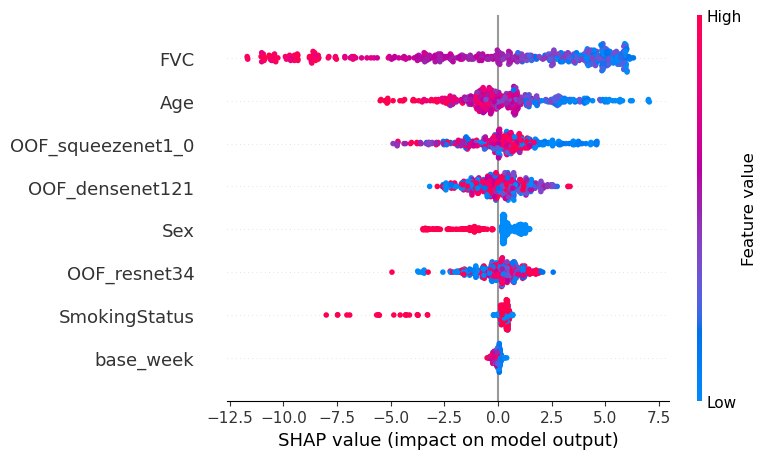

In [19]:
import shap

# Use TreeExplainer for LightGBM model
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)

# Save Model

In [ ]:
print(X)

,Age,FVC,Sex,SmokingStatus,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121,prob_IPF
0,79.0,2315.0,1,2,0.0,0.984993,0.69746,0.442795,0.998843
1,79.0,2214.0,1,2,9.0,0.984993,0.69746,0.442795,0.999624
2,79.0,2061.0,1,2,11.0,0.984993,0.69746,0.442795,0.999682
3,79.0,2144.0,1,2,13.0,0.984993,0.69746,0.442795,0.999671
4,79.0,2069.0,1,2,15.0,0.984993,0.69746,0.442795,0.999662
...,...,...,...,...,...,...,...,...,...
1564,73.0,2908.0,1,0,31.0,0.800631,0.12026,0.400990,0.999885
1565,73.0,2975.0,1,0,43.0,0.800631,0.12026,0.400990,0.999762
1566,73.0,2975.0,1,0,43.0,0.800631,0.12026,0.400990,0.999762
1567,73.0,2774.0,1,0,59.0,0.800631,0.12026,0.400990,0.999768


In [21]:
# Assuming 'model' is your trained LightGBM model
lgb_model.booster_.save_model('../models/lgbm_model.txt')

In [22]:
# LOAD test

bst = lgb.Booster(model_file='../models/lgbm_model.txt')
bst.feature_name()

['Age',
 'FVC',
 'Sex',
 'SmokingStatus',
 'base_week',
 'OOF_resnet34',
 'OOF_squeezenet1_0',
 'OOF_densenet121']